# 7. Validation

In [5]:
!git clone https://github.com/asantos2000/master-degree-santos-anderson.git cfr2sbvr

fatal: destination path 'cfr2sbvr' already exists and is not an empty directory.


In [8]:
!git -C cfr2sbvr/ pull

Already up to date.


In [3]:
!ls

drive  master-degree-santos-anderson  sample_data


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Extract / classify elements

Create a prediction list of elements

In [ ]:
import glob
import json

# Define the path where your JSON files are located
json_files_path = f"../checkpoints/*.json"

# List of all JSON files in the directory
all_files = glob.glob(json_files_path)

pred_elements = []
# Loop through each file
for file_path in all_files:
    #print(file_path.replace("../checkpoints/", ""))
    with open(file_path, "r") as file:
        # Load JSON content
        try:
            data = json.load(file)
        except json.JSONDecodeError:
            #print(f"Error reading {file_path}, skipping this file.")
            continue
        # Filter keys that end with '_P1|llm_response'
        filtered_data = {
            key: value
            for key, value in data.items()
            if key.endswith("_P1|llm_response")
        }

        for value_list in filtered_data.values():
            #print(value_list["id"])
            for element in value_list["content"]["elements"]:
                pred_elements.append(
                    {"doc_id": value_list["id"], "id": element["id"], "expression": element["expression"], "classification": element["classification"], "filename": file_path.replace("../checkpoints/", "")}
                )
                #print(element["id"], element["expression"])


        # Check if filtered_data is empty
        if not filtered_data:
            #print(f"No matching keys in {file_path}, skipping this file.")
            continue

print(len(pred_elements), pred_elements)

388 [{'doc_id': '§ 275.0-2_P1', 'id': 1, 'expression': 'A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.', 'classification': 'Fact Type', 'filename': 'documents-2024-10-20-10.json'}, {'doc_id': '§ 275.0-2_P1', 'id': 2, 'expression': "A person may serve a non-resident investment adviser, non-resident general partner, or non-resident managing agent by furnishing the Commission with one copy of the process, pleadings, or papers, for each named party, and one additional copy for the Commission's records.", 'classification': 'Fact Type', 'filename': 'documents-2024-10-20-10.json'}, {'doc_id': '§ 275.0-2_P1', 'id': 3, 'expression': "If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each na

In [ ]:
print(len(pred_elements), pred_elements)

388 [{'doc_id': '§ 275.0-2_P1', 'id': 1, 'expression': 'A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.', 'classification': 'Fact Type', 'filename': 'documents-2024-10-20-10.json'}, {'doc_id': '§ 275.0-2_P1', 'id': 2, 'expression': "A person may serve a non-resident investment adviser, non-resident general partner, or non-resident managing agent by furnishing the Commission with one copy of the process, pleadings, or papers, for each named party, and one additional copy for the Commission's records.", 'classification': 'Fact Type', 'filename': 'documents-2024-10-20-10.json'}, {'doc_id': '§ 275.0-2_P1', 'id': 3, 'expression': "If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each na

Create a true list of elements

In [ ]:
import json

with open("../data/p1_true_table.json", "r") as f:
    json_data = json.load(f)
    true_elements = []
    for elements in json_data.values():
        #print(elements["id"])
        for element in elements["content"]["elements"]:
            true_elements.append(
                {"doc_id": elements["id"], "id": element["id"], "expression": element["expression"], "classification": element["classification"]}
            )
            #print(element["id"], element["expression"])

    print(true_elements)

[{'doc_id': '§ 275.0-2_P1', 'id': 1, 'expression': 'A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.', 'classification': 'Fact Type'}, {'doc_id': '§ 275.0-2_P1', 'id': 2, 'expression': "A person may serve a non-resident investment adviser, non-resident general partner, or non-resident managing agent by furnishing the Commission with one copy of the process, pleadings, or papers, for each named party, and one additional copy for the Commission's records.", 'classification': 'Fact Type'}, {'doc_id': '§ 275.0-2_P1', 'id': 3, 'expression': "If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commis

Create a dataframe of true and pred elements

In [ ]:
import jellyfish
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Function to group expressions by doc_id
def group_expressions_by_doc_id(expressions_list, is_pred=False):
    doc_id_map = defaultdict(list)
    for item in expressions_list:
        doc_id = item['doc_id']
        if is_pred:
            # Include filename, id, and classification for pred_list items
            expression_info = {
                'id': item['id'],
                'expression': item['expression'],
                'classification_pred': item.get('classification', None),
                'filename_pred': item['filename']
            }
        else:
            # Include id and classification for true_list items
            expression_info = {
                'id': item['id'],
                'expression': item['expression'],
                'classification_true': item.get('classification', None)
            }
        doc_id_map[doc_id].append(expression_info)
    return doc_id_map

# Function to check the similarity between true and pred expressions grouped by doc_id
def check_for_expressions_similarity(true_list, pred_list, threshold=0.7):
    # Build mappings from doc_id to list of expressions
    true_expressions_by_doc_id = group_expressions_by_doc_id(true_list)
    pred_expressions_by_doc_id = group_expressions_by_doc_id(pred_list, is_pred=True)

    results = []
    all_doc_ids = set(true_expressions_by_doc_id.keys()).union(pred_expressions_by_doc_id.keys())

    for doc_id in all_doc_ids:
        true_expressions = true_expressions_by_doc_id.get(doc_id, [])
        pred_expressions = pred_expressions_by_doc_id.get(doc_id, [])

        for pred_item in pred_expressions:
            pred_expr = pred_item['expression']
            pred_id = pred_item['id']
            classification_pred = pred_item.get('classification_pred', None)
            filename_pred = pred_item['filename_pred']
            best_match = None
            best_score = 0
            best_true_id = None
            classification_true = None
            for true_item in true_expressions:
                true_expr = true_item['expression']
                true_id = true_item['id']
                # Calculate the similarity score using the Levenshtein distance
                score = jellyfish.levenshtein_distance(pred_expr, true_expr)
                similarity_score = 1 - (score / max(len(pred_expr), len(true_expr)))  # Normalize to a similarity score

                if similarity_score > best_score:
                    best_score = similarity_score
                    best_match = true_expr
                    best_true_id = true_id
                    classification_true = true_item.get('classification_true', None)
            results.append({
                "doc_id": doc_id,
                "pred_id": pred_id,
                "true_id": best_true_id,
                "classification_pred": classification_pred,
                "classification_true": classification_true,
                "filename_pred": filename_pred,
                "pred_expression": pred_expr,
                "true_expression": best_match,
                "similarity_score": best_score
            })
    return results

# Use the function with your data
similarity_results = check_for_expressions_similarity(true_elements, pred_elements)

# Build the dataframe
df_results = pd.DataFrame(similarity_results)

# Add similarity_classification based on similarity_score
def classify_similarity(score):
    if score == 1.0:
        return 'identical'
    elif score >= 0.9:
        return 'close-match'
    else:
        return 'not-sure'

df_results['similarity_classification'] = df_results['similarity_score'].apply(classify_similarity)

df_results['id_match'] = df_results['pred_id'] == df_results['true_id']
df_results['id_match_label'] = df_results['id_match'].map({True: 'match', False: 'mismatch'})

# Modify the highlight_similarity function to use three colors
def highlight_similarity(val):
    if val == 'identical':
        color = 'green'
    elif val == 'close-match':
        color = 'yellow'
    else:
        color = 'red'
    return f'background-color: {color}'

# Apply the styling to the similarity_classification column
styled_df = df_results.style.applymap(highlight_similarity, subset=["similarity_classification"])
styled_df.set_table_attributes('style="width: 100%; border: 1px solid black;"')
styled_df.set_properties(**{'border': '1px solid black'})

Display the First 10 Rows

In [ ]:
# Select the first 10 rows from df_results
df_top10 = df_results.head(10)

# Apply the styling to the sliced DataFrame
styled_df_top10 = df_top10.style.applymap(highlight_similarity, subset=["similarity_classification"])
styled_df_top10.set_table_attributes('style="width: 100%; border: 1px solid black;"')
styled_df_top10.set_properties(**{'border': '1px solid black'})

# Display the styled DataFrame (if in Jupyter Notebook)
display(styled_df_top10)

/tmp/ipykernel_32889/1059051318.py:5: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled_df_top10 = df_top10.style.applymap(highlight_similarity, subset=["similarity_classification"])


,doc_id,pred_id,true_id,classification_pred,classification_true,filename_pred,pred_expression,true_expression,similarity_score,similarity_classification,id_match,id_match_label
0,§ 275.0-2_P1,1,1,Fact Type,Fact Type,documents-2024-10-20-10.json,"A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.","A person may serve process, pleadings, or other papers on a non-resident investment adviser, or on a non-resident general partner or non-resident managing agent of an investment adviser by serving any or all of its appointed agents.",1.000000,identical,True,match
1,§ 275.0-2_P1,2,2,Fact Type,Fact Type,documents-2024-10-20-10.json,"A person may serve a non-resident investment adviser, non-resident general partner, or non-resident managing agent by furnishing the Commission with one copy of the process, pleadings, or papers, for each named party, and one additional copy for the Commission's records.","A person may serve a non-resident investment adviser, non-resident general partner, or non-resident managing agent by furnishing the Commission with one copy of the process, pleadings, or papers, for each named party, and one additional copy for the Commission's records.",1.000000,identical,True,match
2,§ 275.0-2_P1,3,3,Rule,Rule,documents-2024-10-20-10.json,"If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission.","If process, pleadings, or other papers are served on the Commission as described in this section, the Secretary of the Commission (Secretary) will promptly forward a copy to each named party by registered or certified mail at that party's last address filed with the Commission.",1.000000,identical,True,match
3,§ 275.0-2_P1,4,4,Rule,Rule,documents-2024-10-20-10.json,"If the Secretary certifies that the Commission was served with process, pleadings, or other papers pursuant to paragraph (a)(1) of this section and forwarded these documents to a named party pursuant to paragraph (a)(2) of this section, this certification constitutes evidence of service upon that party.","If the Secretary certifies that the Commission was served with process, pleadings, or other papers pursuant to paragraph (a)(1) of this section and forwarded these documents to a named party pursuant to paragraph (a)(2) of this section, this certification constitutes evidence of service upon that party.",1.000000,identical,True,match
4,§ 275.0-2_P1,5,5,Fact Type,Fact Type,documents-2024-10-20-10.json,"Managing agent means any person, including a trustee, who directs or manages, or who participates in directing or managing, the affairs of any unincorporated organization or association other than a partnership.","Managing agent means any person, including a trustee, who directs or manages, or who participates in directing or managing, the affairs of any unincorporated organization or association other than a partnership.",1.000000,identical,True,match
5,§ 275.0-2_P1,6,6,Fact Type,Fact Type,documents-2024-10-20-10.json,Non-resident means an individual who resides in any place not subject to the jurisdiction of the United States.,Non-resident means an individual who resides in any place not subject to the jurisdiction of the United States.,1.000000,identical,True,match
6,§ 275.0-2_P1,7,7,Fact Type,Fact Type,documents-2024-10-20-10.json,Non-resident means a corporation that is incorporated in or that has its principal office and place of business in any place not subject to the jurisdiction of the United States.,Non-resident means a corporation that is incorporated in or that has its principal office and place of business in any place not subject to the jurisdiction of th

computing the confusion matrix and classification report between classification_true and classification_pred.

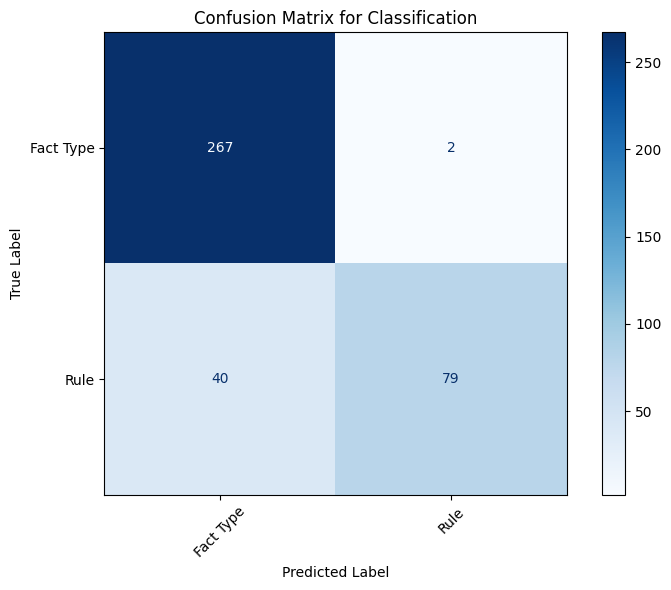

Classification Report:

              precision    recall  f1-score   support

   Fact Type     0.8697    0.9926    0.9271       269
        Rule     0.9753    0.6639    0.7900       119

    accuracy                         0.8918       388
   macro avg     0.9225    0.8282    0.8585       388
weighted avg     0.9021    0.8918    0.8850       388



In [ ]:

# Display the styled dataframe (if in Jupyter Notebook)
# display(styled_df)

# Generate confusion matrix and classification report between classification_true and classification_pred
# Prepare the data
df_evaluation = df_results.dropna(subset=['classification_true', 'classification_pred'])

y_true = df_evaluation['classification_true']
y_pred = df_evaluation['classification_pred']

# Get the unique labels from both y_true and y_pred
labels = np.unique(np.concatenate((y_true.unique(), y_pred.unique())))

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Create a ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for Classification')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Generate the classification report
report = classification_report(y_true, y_pred, labels=labels, digits=4)
print("Classification Report:\n")
print(report)

Analyzing the Distribution of Similarity Classifications

Similarity Classification Distribution:
 similarity_classification
identical    368
not-sure      20
Name: count, dtype: int64


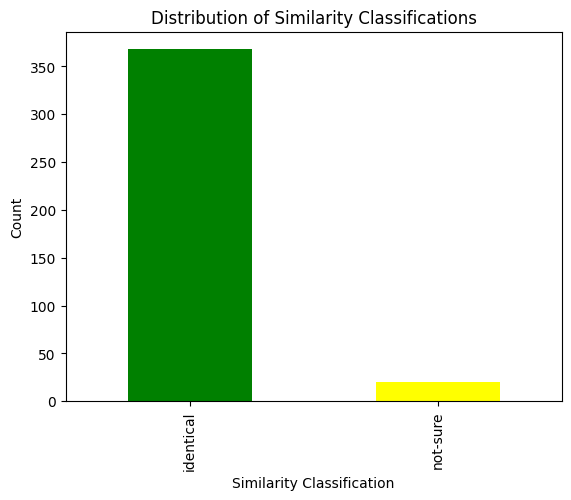

In [ ]:
# Analyze the distribution of similarity classifications
similarity_counts = df_results['similarity_classification'].value_counts()
print("Similarity Classification Distribution:\n", similarity_counts)

# Plotting the distribution
similarity_counts.plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Distribution of Similarity Classifications')
plt.xlabel('Similarity Classification')
plt.ylabel('Count')
plt.show()


### Deep analysis of mismatches

In [ ]:
# Filter the DataFrame to only include rows where similarity_classification is 'not-sure'
df_not_sure = df_results[df_results['similarity_classification'] == 'not-sure']

df_not_sure

,doc_id,pred_id,true_id,classification_pred,classification_true,filename_pred,pred_expression,true_expression,similarity_score,similarity_classification,id_match,id_match_label
156,§ 275.0-5_P1,4,4,Rule,Rule,documents-2024-10-20-10.json,The Commission will order a hearing on the mat...,The Commission will order a hearing on the mat...,0.715517,not-sure,True,match
157,§ 275.0-5_P1,5,5,Fact Type,Fact Type,documents-2024-10-20-10.json,An 'application' means any application for an ...,"For purposes of this rule, an “application” me...",0.832402,not-sure,True,match
171,§ 275.0-5_P1,4,4,Rule,Rule,documents-2024-10-20-4.json,The Commission will order a hearing on the mat...,The Commission will order a hearing on the mat...,0.715517,not-sure,True,match
172,§ 275.0-5_P1,5,5,Fact Type,Fact Type,documents-2024-10-20-4.json,An 'application' means any application for an ...,"For purposes of this rule, an “application” me...",0.832402,not-sure,True,match
201,§ 275.0-5_P1,4,4,Rule,Rule,documents-2024-10-21-1.json,The Commission will order a hearing on the mat...,The Commission will order a hearing on the mat...,0.715517,not-sure,True,match
202,§ 275.0-5_P1,5,5,Fact Type,Fact Type,documents-2024-10-21-1.json,An 'application' means any application for an ...,"For purposes of this rule, an “application” me...",0.832402,not-sure,True,match
217,§ 275.0-5_P1,5,5,Fact Type,Fact Type,documents-2024-10-21-5.json,An 'application' means any application for an ...,"For purposes of this rule, an “application” me...",0.832402,not-sure,True,match
222,§ 275.0-5_P1,5,5,Fact Type,Fact Type,documents-2024-10-22-2.json,An “application” means any application for an ...,"For purposes of this rule, an “application” me...",0.843575,not-sure,True,match
231,§ 275.0-5_P1,4,4,Rule,Rule,documents-2024-10-22-8.json,The Commission will order a hearing on the mat...,The Commission will order a hearing on the mat...,0.715517,not-sure,True,match
232,§ 275.0-5_P1,5,5,Fact Type,Fact Type,documents-2024-10-22-8.json,An 'application' means any application for an ...,"For purposes of this rule, an “application” me...",0.832402,not-sure,True,match


In [ ]:
# Filter for 'close-match' entries
df_close_match = df_results[df_results['similarity_classification'] == 'close-match']

df_close_match

,doc_id,pred_id,true_id,classification_pred,classification_true,filename_pred,pred_expression,true_expression,similarity_score,similarity_classification,id_match,id_match_label


In [ ]:
# Filter entries where the predicted classification does not match the true classification
df_classification_mismatch = df_results[
    df_results['classification_pred'] != df_results['classification_true']
]

# Display the filtered DataFrame
print(df_classification_mismatch)

# Select specific columns to display
columns_to_display = ['doc_id', 'pred_id', 'true_id', 'classification_pred', 'classification_true', 'similarity_score']
df_mismatch_selected = df_classification_mismatch[columns_to_display]

print(df_mismatch_selected)

# Iterate over the mismatches and print details
for index, row in df_classification_mismatch.iterrows():
    print(f"Index: {index}")
    print(f"Doc ID: {row['doc_id']}")
    print(f"Predicted Classification (ID {row['pred_id']}): {row['classification_pred']}")
    print(f"True Classification (ID {row['true_id']}): {row['classification_true']}")
    print(f"Similarity Score: {row['similarity_score']:.4f}")
    print(f"Predicted Expression: {row['pred_expression']}")
    print(f"True Expression: {row['true_expression']}")
    print("-" * 80)

# Get the number of classification mismatches
num_mismatches = len(df_classification_mismatch)
print(f"Number of classification mismatches: {num_mismatches}")

# Calculate mismatch percentage
total_comparisons = len(df_results.dropna(subset=['classification_true', 'classification_pred']))
mismatch_percentage = (num_mismatches / total_comparisons) * 100

print(f"Mismatch Percentage: {mismatch_percentage:.2f}%")

           doc_id  pred_id  true_id classification_pred classification_true  \
219  § 275.0-5_P1        2        2                Rule           Fact Type   
220  § 275.0-5_P1        3        3                Rule           Fact Type   
242  § 275.0-7_P1        5        5           Fact Type                Rule   
243  § 275.0-7_P1        6        6           Fact Type                Rule   
244  § 275.0-7_P1        7        7           Fact Type                Rule   
245  § 275.0-7_P1        8        8           Fact Type                Rule   
251  § 275.0-7_P1        5        5           Fact Type                Rule   
252  § 275.0-7_P1        6        6           Fact Type                Rule   
253  § 275.0-7_P1        7        7           Fact Type                Rule   
254  § 275.0-7_P1        8        8           Fact Type                Rule   
287  § 275.0-7_P1        5        5           Fact Type                Rule   
288  § 275.0-7_P1        6        6           Fact T

In [ ]:
# Filter entries where the predicted classification does not match the true classification
df_classification_mismatch = df_results[
    df_results['classification_pred'] != df_results['classification_true']
]

# Display the number of mismatches
num_mismatches = len(df_classification_mismatch)
print(f"Number of classification mismatches: {num_mismatches}")

# Display the mismatches
print(df_classification_mismatch)

Number of classification mismatches: 42
           doc_id  pred_id  true_id classification_pred classification_true  \
219  § 275.0-5_P1        2        2                Rule           Fact Type   
220  § 275.0-5_P1        3        3                Rule           Fact Type   
242  § 275.0-7_P1        5        5           Fact Type                Rule   
243  § 275.0-7_P1        6        6           Fact Type                Rule   
244  § 275.0-7_P1        7        7           Fact Type                Rule   
245  § 275.0-7_P1        8        8           Fact Type                Rule   
251  § 275.0-7_P1        5        5           Fact Type                Rule   
252  § 275.0-7_P1        6        6           Fact Type                Rule   
253  § 275.0-7_P1        7        7           Fact Type                Rule   
254  § 275.0-7_P1        8        8           Fact Type                Rule   
287  § 275.0-7_P1        5        5           Fact Type                Rule   
288  § 275.0

## References

- [Scikit-LLM: Scikit-Learn Meets Large Language Models](https://medium.com/@sayedebad.777/scikit-llm-scikit-learn-meets-large-language-models-986ff149abcc)
- [23 Game-Changing Python Packages You Are Missing Out On](https://medium.com/pythoneers/23-underrated-python-packages-you-didnt-knew-existed-36dbb0a417c0) - 19 Jellyfish